In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import torch.nn.functional as f 
from torch.autograd import Variable
torch.backends.cudnn.deterministic = True
import pandas as pd
import numpy as np
import torch.utils.data as data_utils
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn import metrics
import random 
from matplotlib import pyplot as plt

from sklearn import decomposition

from sklearn import manifold
from scipy import stats

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
def plot_confusion_matrix(labels, pred_labels, ax):
    #fig = plt.figure(figsize = (10, 10));
    #ax = fig.add_subplot(1, 1, 1);
    cm = metrics.confusion_matrix(labels, pred_labels, normalize='pred');
    cm = metrics.ConfusionMatrixDisplay(cm);
    cm.plot(cmap = 'Blues', ax = ax)
    cm.im_.colorbar.remove()


def get_predictions(model, iterator, device):
    model.eval()

    images = []
    labels = []
    probs = []
    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _, _ = model(x)

            y_prob = f.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

def regularization_method(params):
    l1_regularization = 0
    l2_regularization = 0
    lambda1 = 0.001
    lambda2 = 0.001
    for param in params:
        l1_regularization += torch.norm(param, 1)**2
        l2_regularization += torch.norm(param, 2)**2
    loss = loss + lambda1*l1_regularization + lambda2*l2_regularization
    
def plot_weights(weights, n_weights):

    rows = int(np.sqrt(n_weights))
    cols = int(np.sqrt(n_weights))

    fig = plt.figure(figsize = (20, 10))
    
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(weights[i].view(5, 10).cpu().numpy(), cmap = 'bone')
        #plt.title(str(train_target[i]))
        ax.axis('off')
        
def get_pca(data, data_test=None, n_components = 2):
    pca = decomposition.PCA()
    
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    
    if data_test is not None: 
        pca_data_test = pca.transform(data_test)
        return pca_data, pca_data_test 
    
    return pca_data


def get_tsne(data, data_test = None, n_components = 2, n_curves = None):
    if n_curves is not None:
        data = data[:n_curves]
    tsne = manifold.TSNE(n_components = n_components, random_state = 0)
    tsne_data = tsne.fit_transform(data)
    
    if data_test is not None: 
        tsne_data_test = tsne.fit_transform(data_test)
        return tsne_data, tsne_data_test  
    
    return tsne_data

def get_representations(model, iterator, device):

    model.eval()
    outputs = []
    intermediates = []
    intermediates2 = []
    labels = []

    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y_pred, h2, h1 = net(x)
            outputs.append(y_pred.cpu())
            intermediates.append(h1.cpu())
            intermediates2.append(h2.cpu())
            labels.append(y)
        
    outputs = torch.cat(outputs, dim = 0)
    intermediates = torch.cat(intermediates, dim = 0)
    intermediates2 = torch.cat(intermediates2, dim = 0)
    labels = torch.cat(labels, dim = 0)

    return outputs, intermediates, intermediates2, labels

def plot_representations(data, labels, ax, n_curves = None):
    if n_curves is not None:
        data = data[:n_curves]
        labels = labels[:n_curves]
    #fig = plt.figure(figsize = (10, 10))
    #ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c = labels, alpha =0.5)
    handles, labels = scatter.legend_elements()
    legend = ax.legend(handles = handles, labels = labels)

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

In [5]:
device

device(type='cuda', index=0)

In [6]:
number = 1
fileTrain = '/home/franciscoperez/Documents/GitHub/data/BIASEDFATS/Train_rrlyr-'+str(number)+'.csv'
fileTest = '/home/franciscoperez/Documents/GitHub/data/BIASEDFATS/Test_rrlyr-'+str(number)+'.csv'
train_dataset = pd.read_csv(fileTrain, index_col ='Unnamed: 0')
test_dataset = pd.read_csv(fileTest)

In [7]:
try:
    train_dataset =  train_dataset.drop(['Pred', 'Pred2', 'h', 'e', 'u','ID'], axis = 1)
    for col in train_dataset.columns:
        if col not in ['label']:
            if train_dataset[col].var()==0:
                print(col)
                del train_dataset[col]
    test_dataset = test_dataset[list(train_dataset.columns)]
except:
    print(col)
    print('---')

Freq1_harmonics_rel_phase_0
Freq2_harmonics_rel_phase_0
Freq3_harmonics_rel_phase_0


In [8]:
n = 10000#train_dataset.shape[0] 
epsilon = 0.1
input_size = train_dataset.shape[1]-1
hidden_size = 100
hidden_size2 = 100
num_classes = 2
num_epochs = 100
batch_size = 32
learning_rate = 0.001
learning_rate2 = 0.001
regularization = False
add_DR_based_data = True


In [9]:
train_dataset = train_dataset.sample(n)
train_dataset.shape


(10000, 61)

In [10]:
test_dataset.shape

(28625, 61)

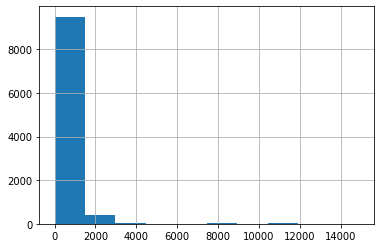

In [11]:
train_dataset['PeriodLS'].hist()
plt.show()

In [12]:
label = train_dataset['label']
del train_dataset['label']


train_dataset_z=(train_dataset-train_dataset.mean())/train_dataset.std()
z_scores = stats.zscore(train_dataset_z)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
train_dataset['label'] = label
train_dataset = train_dataset[filtered_entries]
print(train_dataset.shape)


(7806, 61)


In [13]:
label = test_dataset['label']
del test_dataset['label']

print(test_dataset.shape)

test_dataset_z=(test_dataset-test_dataset.mean())/test_dataset.std()
z_scores = stats.zscore(test_dataset_z)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
test_dataset['label'] = label

print(test_dataset.shape)

test_dataset = test_dataset[filtered_entries]



(28625, 60)
(28625, 61)


In [14]:
test_dataset = test_dataset[['PeriodLS', 'Amplitude', 'AndersonDarling', 'Autocor_length', 'Beyond1Std',
       'CAR_mean', 'CAR_sigma', 'CAR_tau', 'Con', 'Eta_e',
       'FluxPercentileRatioMid20', 'FluxPercentileRatioMid35',
       'FluxPercentileRatioMid50', 'FluxPercentileRatioMid65',
       'FluxPercentileRatioMid80', 'Freq1_harmonics_amplitude_0',
       'Freq1_harmonics_amplitude_1', 'Freq1_harmonics_amplitude_2',
       'Freq1_harmonics_amplitude_3', 'Freq1_harmonics_rel_phase_1',
       'Freq1_harmonics_rel_phase_2', 'Freq1_harmonics_rel_phase_3',
       'Freq2_harmonics_amplitude_0', 'Freq2_harmonics_amplitude_1',
       'Freq2_harmonics_amplitude_2', 'Freq2_harmonics_amplitude_3',
       'Freq2_harmonics_rel_phase_1', 'Freq2_harmonics_rel_phase_2',
       'Freq2_harmonics_rel_phase_3', 'Freq3_harmonics_amplitude_0',
       'Freq3_harmonics_amplitude_1', 'Freq3_harmonics_amplitude_2',
       'Freq3_harmonics_amplitude_3', 'Freq3_harmonics_rel_phase_1',
       'Freq3_harmonics_rel_phase_2', 'Freq3_harmonics_rel_phase_3', 'Gskew',
       'LinearTrend', 'MaxSlope', 'Mean', 'Meanvariance', 'MedianAbsDev',
       'MedianBRP', 'PairSlopeTrend', 'PercentAmplitude',
       'PercentDifferenceFluxPercentile', 'Period_fit', 'Psi_CS',
       'Psi_eta', 'Q31', 'Rcs', 'Skew', 'SlottedA_length', 'SmallKurtosis',
       'Std', 'StetsonK', 'StetsonK_AC', 'StructureFunction_index_21',
       'StructureFunction_index_31', 'StructureFunction_index_32', 'label']]

In [15]:
train_dataset = train_dataset[['PeriodLS', 'Amplitude', 'AndersonDarling', 'Autocor_length', 'Beyond1Std',
       'CAR_mean', 'CAR_sigma', 'CAR_tau', 'Con', 'Eta_e',
       'FluxPercentileRatioMid20', 'FluxPercentileRatioMid35',
       'FluxPercentileRatioMid50', 'FluxPercentileRatioMid65',
       'FluxPercentileRatioMid80', 'Freq1_harmonics_amplitude_0',
       'Freq1_harmonics_amplitude_1', 'Freq1_harmonics_amplitude_2',
       'Freq1_harmonics_amplitude_3', 'Freq1_harmonics_rel_phase_1',
       'Freq1_harmonics_rel_phase_2', 'Freq1_harmonics_rel_phase_3',
       'Freq2_harmonics_amplitude_0', 'Freq2_harmonics_amplitude_1',
       'Freq2_harmonics_amplitude_2', 'Freq2_harmonics_amplitude_3',
       'Freq2_harmonics_rel_phase_1', 'Freq2_harmonics_rel_phase_2',
       'Freq2_harmonics_rel_phase_3', 'Freq3_harmonics_amplitude_0',
       'Freq3_harmonics_amplitude_1', 'Freq3_harmonics_amplitude_2',
       'Freq3_harmonics_amplitude_3', 'Freq3_harmonics_rel_phase_1',
       'Freq3_harmonics_rel_phase_2', 'Freq3_harmonics_rel_phase_3', 'Gskew',
       'LinearTrend', 'MaxSlope', 'Mean', 'Meanvariance', 'MedianAbsDev',
       'MedianBRP', 'PairSlopeTrend', 'PercentAmplitude',
       'PercentDifferenceFluxPercentile', 'Period_fit', 'Psi_CS',
       'Psi_eta', 'Q31', 'Rcs', 'Skew', 'SlottedA_length', 'SmallKurtosis',
       'Std', 'StetsonK', 'StetsonK_AC', 'StructureFunction_index_21',
       'StructureFunction_index_31', 'StructureFunction_index_32', 'label']]

In [16]:
test_dataset_pred = test_dataset.copy()
train_dataset_pred = train_dataset.copy()

In [17]:
train_dataset.head()

,PeriodLS,Amplitude,AndersonDarling,Autocor_length,Beyond1Std,CAR_mean,CAR_sigma,CAR_tau,Con,Eta_e,...,Skew,SlottedA_length,SmallKurtosis,Std,StetsonK,StetsonK_AC,StructureFunction_index_21,StructureFunction_index_31,StructureFunction_index_32,label
391262,74.277705,0.15100,0.001250,10,0.346667,22.791959,0.537868,0.619429,0.02349,14.104876,...,0.194838,17.79498,-0.488208,0.078843,0.814231,0.784707,1.801910,2.535099,1.448028,ClassB
230291,1020.470095,0.01750,0.115532,2,0.363333,274.744191,0.211135,0.053812,0.00000,5.686240,...,0.133719,5.69361,0.111186,0.009347,0.793480,0.745731,1.620815,2.129265,1.607298,ClassB
26148,0.486126,0.02575,0.536316,2,0.299065,39.534998,0.553698,0.389701,0.00000,6307.485427,...,-0.058798,4.92600,-0.091798,0.012686,0.791180,0.738202,1.453116,1.593353,1.206530,ClassB
34003,921.153420,0.01825,0.253883,5,0.283186,206.752429,0.049652,0.068576,0.00000,8.364235,...,-0.502323,1.18029,1.457469,0.010113,0.777735,0.741196,1.317766,1.621916,1.385394,ClassB
189282,1.139047,0.45500,0.000000,1,0.220000,18.179650,0.189635,1.087083,0.00000,17.117858,...,1.129390,1.89933,2.278362,0.219409,0.742077,0.726959,2.211178,3.532070,1.632040,ClassB


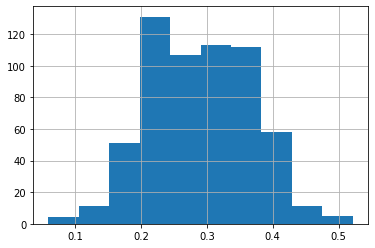

In [18]:
train_dataset[train_dataset.label=='ClassA'].Amplitude.hist()

In [19]:
samples = 3000
samples1 = samples*2
number_columns = train_dataset.shape[1]
option = 1


data_prior = pd.DataFrame(0, index=np.arange(1), columns=train_dataset.columns)

if add_DR_based_data:
    #option 1
    if option == 1:
        for i in range(samples1):
            new_data = pd.DataFrame(0, index=np.arange(1), columns=train_dataset.columns) 
            new_data.columns = train_dataset.columns
            new_data['PeriodLS']= (np.random.uniform(0.2-epsilon,1.0+epsilon))#-minimum_period)/(maximum_period-minimum_period)
            new_data['label'] = 'Noise'
            frames = [data_prior, new_data]
            data_prior = pd.concat(frames, ignore_index=True)
    
    if option==1:
        #option 2
        for i in range(samples):
            new_data = pd.DataFrame(0, index=np.arange(1), columns=train_dataset.columns) 
            new_data.columns = train_dataset.columns
            new_data['PeriodLS']=(np.random.uniform(0.2-epsilon,0.2+epsilon))#-minimum_period)/(maximum_period-minimum_period)
            new_data['label'] = 'Noise'
            frames = [data_prior, new_data]
            data_prior = pd.concat(frames, ignore_index=True)


        for i in range(samples):    
            new_data = pd.DataFrame(0, index=np.arange(1), columns=train_dataset.columns) 
            new_data.columns = train_dataset.columns
            new_data['PeriodLS']=(np.random.uniform(1.0-epsilon,1.0+epsilon))
            new_data['label'] = 'Noise'
            frames = [data_prior, new_data]
            data_prior = pd.concat(frames, ignore_index=True)

        
    #option 3
    if option==1:
        for i in range(samples):    
            new_data = pd.DataFrame(0, index=np.arange(1), columns=train_dataset.columns) #pd.DataFrame([train_dataset.sample(1000).mean()]).T
            new_data['PeriodLS']= 1.0
            new_data['label'] = 'Noise'
            frames = [data_prior, new_data]
            data_prior = pd.concat(frames, ignore_index=True)


        for i in range(samples):    
            new_data = pd.DataFrame(0, index=np.arange(1), columns=train_dataset.columns) 
            new_data.columns = train_dataset.columns
            new_data['PeriodLS']= 0.2
            new_data['label'] = 'Noise'
            frames = [data_prior, new_data]
            data_prior = pd.concat(frames, ignore_index=True)


In [20]:
data_prior.describe()

,PeriodLS,Amplitude,AndersonDarling,Autocor_length,Beyond1Std,CAR_mean,CAR_sigma,CAR_tau,Con,Eta_e,...,Rcs,Skew,SlottedA_length,SmallKurtosis,Std,StetsonK,StetsonK_AC,StructureFunction_index_21,StructureFunction_index_31,StructureFunction_index_32
count,18001.000000,18001.0,18001.0,18001.0,18001.0,18001.0,18001.0,18001.0,18001.0,18001.0,...,18001.0,18001.0,18001.0,18001.0,18001.0,18001.0,18001.0,18001.0,18001.0,18001.0
mean,0.600664,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.368610,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.604236,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.099987,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.1, random_state=42)

In [22]:
train_dataset_prior, val_dataset_prior = train_test_split(data_prior, test_size=0.1, random_state=42)

In [23]:
train_dataset_prior['label'] = train_dataset_prior['label'].str.replace('ClassA', '1')
train_dataset_prior['label'] = train_dataset_prior['label'].str.replace('ClassB', '0')
train_dataset_prior['label'] = train_dataset_prior['label'].str.replace('Noise', '0.5')

train_target_prior = torch.tensor(train_dataset_prior['label'].values.astype(np.float32))
train_prior = torch.tensor(train_dataset_prior.drop('label', axis = 1).values.astype(np.float32)) 
train_prior = f.normalize(train_prior)
train_tensor_prior = data_utils.TensorDataset(train_prior, train_target_prior) 
train_loader_prior = data_utils.DataLoader(dataset = train_tensor_prior, batch_size = batch_size)

/home/franciscoperez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/franciscoperez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/franciscoperez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

In [24]:
train_dataset_prior.head()

,PeriodLS,Amplitude,AndersonDarling,Autocor_length,Beyond1Std,CAR_mean,CAR_sigma,CAR_tau,Con,Eta_e,...,Skew,SlottedA_length,SmallKurtosis,Std,StetsonK,StetsonK_AC,StructureFunction_index_21,StructureFunction_index_31,StructureFunction_index_32,label
6027,0.115450,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.5
16954,0.200000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.5
4286,0.659811,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.5
16961,0.200000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.5
13785,1.000000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.5


In [25]:
val_dataset_prior['label'] = val_dataset_prior['label'].str.replace('ClassA', '1')
val_dataset_prior['label'] = val_dataset_prior['label'].str.replace('ClassB', '0')
val_dataset_prior['label'] = val_dataset_prior['label'].str.replace('Noise', '0.5')
val_target_prior = torch.tensor(val_dataset_prior['label'].values.astype(np.float32))
val_prior = torch.tensor(val_dataset_prior.drop('label', axis = 1).values.astype(np.float32)) 
val_prior = f.normalize(val_prior)
val_tensor_prior = data_utils.TensorDataset(val_prior, val_target_prior) 
val_loader_prior = data_utils.DataLoader(dataset = val_tensor_prior, batch_size = 32)

/home/franciscoperez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/franciscoperez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/franciscoperez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

Cases using DR 1: Period $ \in [0.2,1.0]$ days

In [26]:
train_dataset['label'] = train_dataset['label'].str.replace('ClassA', '1')
train_dataset['label'] = train_dataset['label'].str.replace('ClassB', '0')
train_dataset['label'] = train_dataset['label'].str.replace('Noise', '0.5')
train_target = torch.tensor(train_dataset['label'].values.astype(np.float32))
train = torch.tensor(train_dataset.drop('label', axis = 1).values.astype(np.float32)) 
train = f.normalize(train)
train_tensor = data_utils.TensorDataset(train, train_target) 
train_loader = data_utils.DataLoader(dataset = train_tensor, batch_size = batch_size)

In [27]:
train_dataset_pred['label'] = train_dataset_pred['label'].str.replace('ClassA', '1')
train_dataset_pred['label'] = train_dataset_pred['label'].str.replace('ClassB', '0')
train_dataset_pred['label'] = train_dataset_pred['label'].str.replace('Noise', '0.5')
train_target_pred = torch.tensor(train_dataset_pred['label'].values.astype(np.float32))
train_pred = torch.tensor(train_dataset_pred.drop('label', axis = 1).values.astype(np.float32)) 
train_pred = f.normalize(train_pred)
train_tensor_pred = data_utils.TensorDataset(train_pred, train_target_pred) 
train_loader_pred = data_utils.DataLoader(dataset = train_tensor_pred, batch_size = batch_size)

In [28]:
val_dataset['label'] = val_dataset['label'].str.replace('ClassA', '1')
val_dataset['label'] = val_dataset['label'].str.replace('ClassB', '0')
val_dataset['label'] = val_dataset['label'].str.replace('Noise', '0.5')
val_target = torch.tensor(val_dataset['label'].values.astype(np.float32))
val = torch.tensor(val_dataset.drop('label', axis = 1).values.astype(np.float32)) 
val = f.normalize(val)
val_tensor = data_utils.TensorDataset(val, val_target) 
val_loader = data_utils.DataLoader(dataset = val_tensor, batch_size = batch_size)

In [29]:
test_dataset['label'] = test_dataset['label'].str.replace('ClassA', '1')
test_dataset['label'] = test_dataset['label'].str.replace('ClassB', '0')
test_dataset['label'] = test_dataset['label'].str.replace('Noise', '0.5')
test_target = torch.tensor(test_dataset['label'].values.astype(np.float32))
test = torch.tensor(test_dataset.drop('label', axis = 1).values.astype(np.float32)) 
test = f.normalize(test)
test_tensor = data_utils.TensorDataset(test, test_target) 
test_loader = data_utils.DataLoader(dataset = test_tensor, batch_size = batch_size)

In [30]:
test_dataset_pred['label'] = test_dataset_pred['label'].str.replace('ClassA', '1')
test_dataset_pred['label'] = test_dataset_pred['label'].str.replace('ClassB', '0')
test_dataset_pred['label'] = test_dataset_pred['label'].str.replace('Noise', '0.5')
test_target_pred = torch.tensor(test_dataset_pred['label'].values.astype(np.float32))
test_pred = torch.tensor(test_dataset_pred.drop('label', axis = 1).values.astype(np.float32)) 
test_pred = f.normalize(test_pred)
test_tensor_pred = data_utils.TensorDataset(test_pred, test_target_pred) 
test_loader_pred = data_utils.DataLoader(dataset = test_tensor_pred, batch_size = batch_size)

In [31]:
val_dataset.head()

,PeriodLS,Amplitude,AndersonDarling,Autocor_length,Beyond1Std,CAR_mean,CAR_sigma,CAR_tau,Con,Eta_e,...,Skew,SlottedA_length,SmallKurtosis,Std,StetsonK,StetsonK_AC,StructureFunction_index_21,StructureFunction_index_31,StructureFunction_index_32,label
174117,0.324448,0.1820,0.000001,1,0.393333,112.044327,0.418271,0.168959,0.000000,12.974136,...,0.027193,1.90251,-0.969659,0.106944,0.850240,0.759838,1.700818,2.238206,1.406132,1
213564,0.997173,0.0160,0.222459,1,0.336667,16.991810,0.037819,0.902818,0.000000,277.007192,...,0.087971,3.87098,-0.356370,0.008325,0.808911,0.720602,1.982758,2.933661,1.545561,0
276651,155.905153,0.2435,0.000000,7,0.350000,45.616866,0.439809,0.317784,0.000000,0.125252,...,0.386223,26.57018,-1.091240,0.144788,0.880564,0.901119,1.757013,2.421897,1.407768,0
71748,69.379738,0.1685,0.086394,8,0.363333,0.221403,0.016843,65.831294,0.010067,23.314511,...,0.152966,14.50403,-0.563920,0.088828,0.811878,0.769850,1.610450,2.047596,1.370289,0
285067,29.686717,0.0265,0.017440,4,0.292683,17.326060,0.096043,0.876740,0.006173,89.729155,...,0.408502,3.90383,0.748994,0.012943,0.754260,0.780803,2.021907,3.077439,1.617622,0


In [32]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size,hidden_size2, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        #self.relu = nn.ReLU()
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size2)  
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, num_classes) 
        #self.sigmoid = nn.Sigmoid()
        #self.dropout = nn.Dropout(p=0.1)
        #self.batchnorm1 = nn.BatchNorm1d(hidden_size)
        #self.batchnorm2 = nn.BatchNorm1d(hidden_size)
        
        
    def forward(self, x):
        out1 = self.fc1(x)
        #out = self.batchnorm1(out)
        #out = self.relu(out)
        out = self.relu(out1)
        out2 = self.fc2(out)
        #out = self.batchnorm1(out)
        out = self.relu2(out)
        out3 = self.fc3(out)
        #x = self.dropout(x)
        #out = self.sigmoid(out)
        return out3, out2, out1
  
#net_prior = Net(input_size, hidden_size, hidden_size2, num_classes)

#net_prior.cuda()

net = Net(input_size, hidden_size, hidden_size2, num_classes)

#use_cuda = torch.cuda.is_available()

net.cuda()
#net = nn.DataParallel(net)

Net(
  (fc1): Linear(in_features=60, out_features=100, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=100, out_features=2, bias=True)
)

In [33]:
param_l1 = list(net.fc1.parameters())
param_l2 = list(net.fc2.parameters())
param_l3 = list(net.fc3.parameters())
#print(len(param))
print(len(param_l1[0]))
print(len(param_l1[:][0]))
#print(len(param[1]))

100
100


In [34]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()  
#criterion = nn.BCELoss()
#criterion = nn.BCEWithLogitsLoss()

prior_parameters = [
    {'params': param_l1[:][0]},
    {'params': net.fc2.parameters()},
    {'params': net.fc3.parameters()}
]
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)  
optimizer_prior = torch.optim.Adam(prior_parameters, lr=learning_rate2)  

In [35]:
def softmax(x): 
    return x.exp() / (x.exp().sum(-1)).unsqueeze(-1)

In [36]:
def custom_loss(output, labels, weigths=None, weigths_prior=None):
    regularization_loss = 0
    lambda_1 = 0.00001
    if weigths is not None: 
        regularization_loss += fast_cdist(weigths, weigths_prior)
            #print(regularization_loss)
        loss = criterion(outputs, labels) + lambda_1*regularization_loss #nn.L1Loss()(weigths, weigths)
    else:
        loss = criterion(outputs, labels)
        #print(loss)
    return loss

In [37]:
def custom_loss_auxiliar(output, lambda_pen=10.0):
    #print(softmax(output)[:,1])
    expected_loss = softmax(output)[:,1].mean()
    #print(expected_loss)
    threshold = torch.tensor(0.5).cuda()
    aux_loss = torch.tensor(expected_loss-threshold, requires_grad=True).cuda()
    #print(aux_loss**2)
    return torch.tensor(lambda_pen*aux_loss**2, requires_grad=True).cuda()

In [38]:
def fast_cdist(x1, x2):
    res=f.mse_loss(x1, x2, size_average=False)
    #res=f.l1_loss(x1, x2, size_average=False)
    return res

In [39]:
from itertools import cycle
aux_loss_activated = True
# Train the Model   
hist_train = []
hist_val = []
num_epochs_prior = 200
for epoch in range(num_epochs_prior):
    epoch_loss = 0.0
    running_loss = 0.0
    epoch_loss_prior = 0.0    
    running_loss_prior = 0.0
    
    for item1, item2 in zip(train_loader, cycle(train_loader_prior)):
        star_prior, labels_prior = item2
        star, labels = item1
        
        star = Variable(star.view(-1, input_size)).cuda()
        labels = Variable(labels).cuda()
        optimizer.zero_grad()  
        outputs, _, _ = net(star)
        loss = criterion(outputs, labels.long())      
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if aux_loss_activated:
            star_prior = Variable(star_prior.view(-1, input_size)).cuda()
            labels_prior = Variable(labels_prior).cuda()
            optimizer_prior.zero_grad()  # zero the gradient buffer
            outputs_prior, _, _ = net(star_prior)
            loss_prior = custom_loss_auxiliar(outputs_prior)                
            loss_prior.backward()
            optimizer_prior.step()
            epoch_loss_prior += outputs_prior.shape[0] * loss_prior.item()      
            running_loss_prior += loss_prior.item()
        
    hist_train.append(running_loss/len(train_loader))    
    print('training:', 'epoch: ', str(epoch+1),' loss: ', str(running_loss/len(train_loader)))
    
    epoch_loss = 0.0
    running_loss = 0.0
    for i, (star, labels) in enumerate(val_loader):  
        
        star = Variable(star.view(-1, input_size)).cuda()
        labels = Variable(labels).cuda()
        optimizer.zero_grad()  
        outputs, _, _ = net(star)
        loss = criterion(outputs, labels.long())      
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print('validating:', 'epoch: ', str(epoch+1),' loss: ', str(running_loss / len(val_loader)))
    hist_val.append(running_loss / len(val_loader))

/home/franciscoperez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/home/franciscoperez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


training: epoch:  1  loss:  0.3208041700111194
validating: epoch:  1  loss:  0.18042916044592858
training: epoch:  2  loss:  0.1975078943778168
validating: epoch:  2  loss:  0.14477040976285935
training: epoch:  3  loss:  0.16397597669539127
validating: epoch:  3  loss:  0.12116490200161933
training: epoch:  4  loss:  0.14101041978733106
validating: epoch:  4  loss:  0.10437126800417901
training: epoch:  5  loss:  0.12448381129652261
validating: epoch:  5  loss:  0.09172229900956154
training: epoch:  6  loss:  0.11202365448698401
validating: epoch:  6  loss:  0.08175303779542446
training: epoch:  7  loss:  0.10203999758444049
validating: epoch:  7  loss:  0.07343964651226997
training: epoch:  8  loss:  0.09373929480260068
validating: epoch:  8  loss:  0.06647982396185398
training: epoch:  9  loss:  0.08663475843654438
validating: epoch:  9  loss:  0.06051179260015488
training: epoch:  10  loss:  0.08050958776677197
validating: epoch:  10  loss:  0.05533615238964558
training: epoch:  11

training: epoch:  83  loss:  0.014134423791917719
validating: epoch:  83  loss:  0.005645905280252919
training: epoch:  84  loss:  0.014013399077124301
validating: epoch:  84  loss:  0.005576468872604891
training: epoch:  85  loss:  0.013845527702307498
validating: epoch:  85  loss:  0.005473292212118394
training: epoch:  86  loss:  0.013683692774396728
validating: epoch:  86  loss:  0.005444204589584842
training: epoch:  87  loss:  0.01360465769275007
validating: epoch:  87  loss:  0.005392768766905647
training: epoch:  88  loss:  0.0134904800766063
validating: epoch:  88  loss:  0.005237074127653614
training: epoch:  89  loss:  0.013354997449046509
validating: epoch:  89  loss:  0.005144161690841429
training: epoch:  90  loss:  0.013223978791872718
validating: epoch:  90  loss:  0.00512591254839208
training: epoch:  91  loss:  0.013114471465550278
validating: epoch:  91  loss:  0.005028581029037014
training: epoch:  92  loss:  0.012985851819923316
validating: epoch:  92  loss:  0.004

training: epoch:  163  loss:  0.008519081449379552
validating: epoch:  163  loss:  0.0019255041732321842
training: epoch:  164  loss:  0.008487837731478397
validating: epoch:  164  loss:  0.0018167585306400724
training: epoch:  165  loss:  0.008340177063920155
validating: epoch:  165  loss:  0.0019413402848476836
training: epoch:  166  loss:  0.008416342043016233
validating: epoch:  166  loss:  0.0018511132666753837
training: epoch:  167  loss:  0.008381476333174346
validating: epoch:  167  loss:  0.0018800174273019366
training: epoch:  168  loss:  0.008380399243668018
validating: epoch:  168  loss:  0.0018026905105671177
training: epoch:  169  loss:  0.008289046486739112
validating: epoch:  169  loss:  0.0018386833255135571
training: epoch:  170  loss:  0.008256135218041229
validating: epoch:  170  loss:  0.0017739857675951498
training: epoch:  171  loss:  0.00822264818707481
validating: epoch:  171  loss:  0.0017629235696313117
training: epoch:  172  loss:  0.008161177833575162
valid

In [40]:
# Test the Model
correct = 0
total = 0
for star, labels in test_loader:
    images = Variable(star.view(-1, input_size)).cuda()
    outputs, _, _ = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted.cpu() == labels.long()).sum()
print('Accuracy of the network on test objects: %d %%' % (100 * correct / total))
acc_testing = 100 *correct / total
print(np.asarray(acc_testing))

Accuracy of the network on test objects: 82 %
82


In [41]:
correct = 0
total = 0
for star, labels in train_loader:
    images = Variable(star.view(-1, input_size)).cuda()
    outputs, _, _ = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted.cpu() == labels.long()).sum()
print('Accuracy of the network on train objects: %d %%' % (100 * correct / total))
acc_training = 100 *correct / total

Accuracy of the network on train objects: 99 %


In [42]:
# Save the Model
torch.save(net.state_dict(), 'model.pkl')

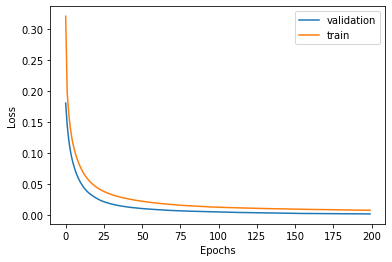

In [43]:
plt.plot(hist_val, label ='validation')
plt.plot(hist_train, label ='train')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.savefig('images/'+str(samples)+'_'+str(epsilon)+'_'+str(n)+"_"+str(hidden_size)+"_Loss_Training.png")
plt.show()

In [44]:
csv_file = open("size_MLP_noise.csv", "a")
csv_file.write(str(np.asarray(acc_testing))+","+str(np.asarray(acc_training))+","+str(samples)+","+str(epsilon)+","+str(n)+","+str(hidden_size)+"\n")
csv_file.close()

In [45]:
outputs, intermediates, intermediates2, labels = get_representations(net, train_loader, device)
outputs_test, intermediates_test, intermediates2_test, labels_test = get_representations(net, test_loader, device)

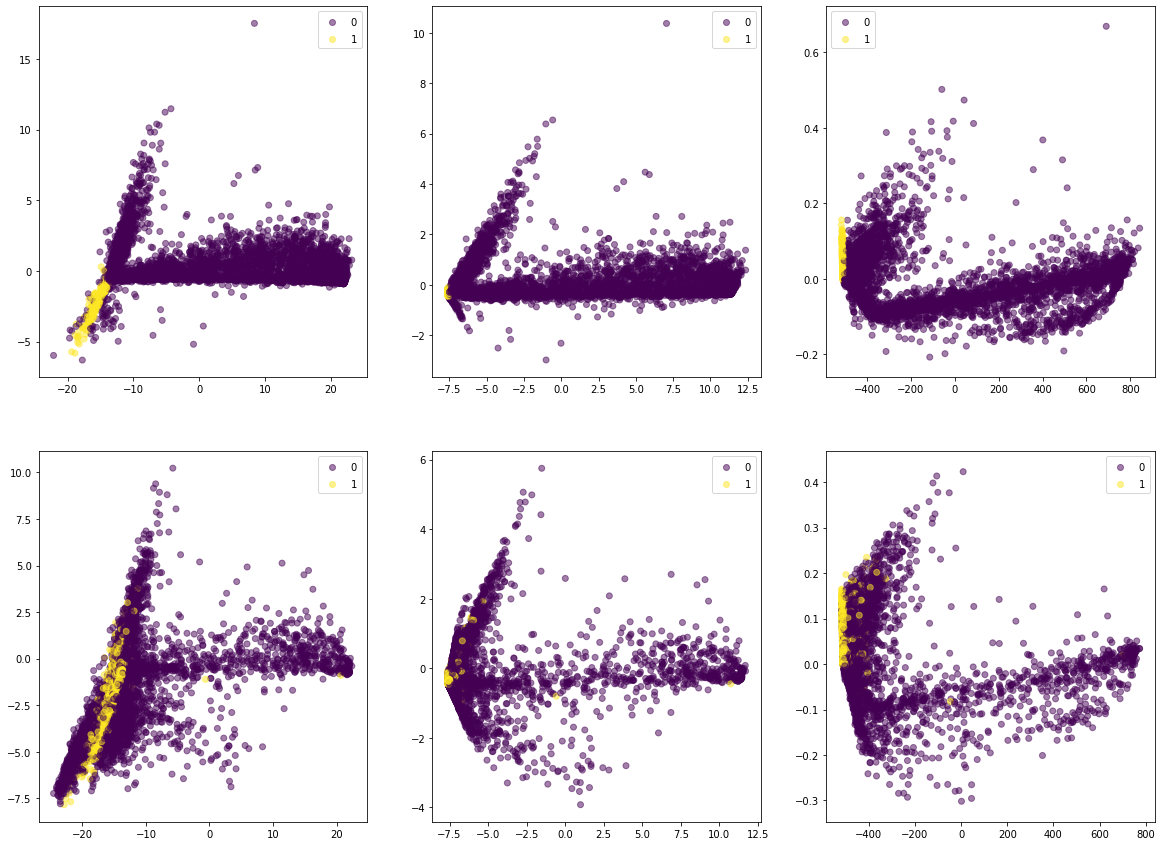

In [46]:
intermediate_pca_data, intermediate_pca_data_test = get_pca(intermediates, data_test=intermediates_test)

fig, axs = plt.subplots(2, 3, figsize=(20,15))

plot_representations(intermediate_pca_data, labels, axs[0, 0])
plot_representations(intermediate_pca_data_test, labels_test, axs[1, 0])

intermediate2_pca_data, intermediate2_pca_data_test = get_pca(intermediates2, data_test=intermediates2_test)
plot_representations(intermediate2_pca_data, labels, axs[0, 1])
plot_representations(intermediate2_pca_data_test, labels_test, axs[1, 1])

output_pca_data, output_pca_data_test = get_pca(outputs, data_test=outputs_test)
plot_representations(output_pca_data, labels, axs[0, 2])
plot_representations(output_pca_data_test, labels_test, axs[1, 2])

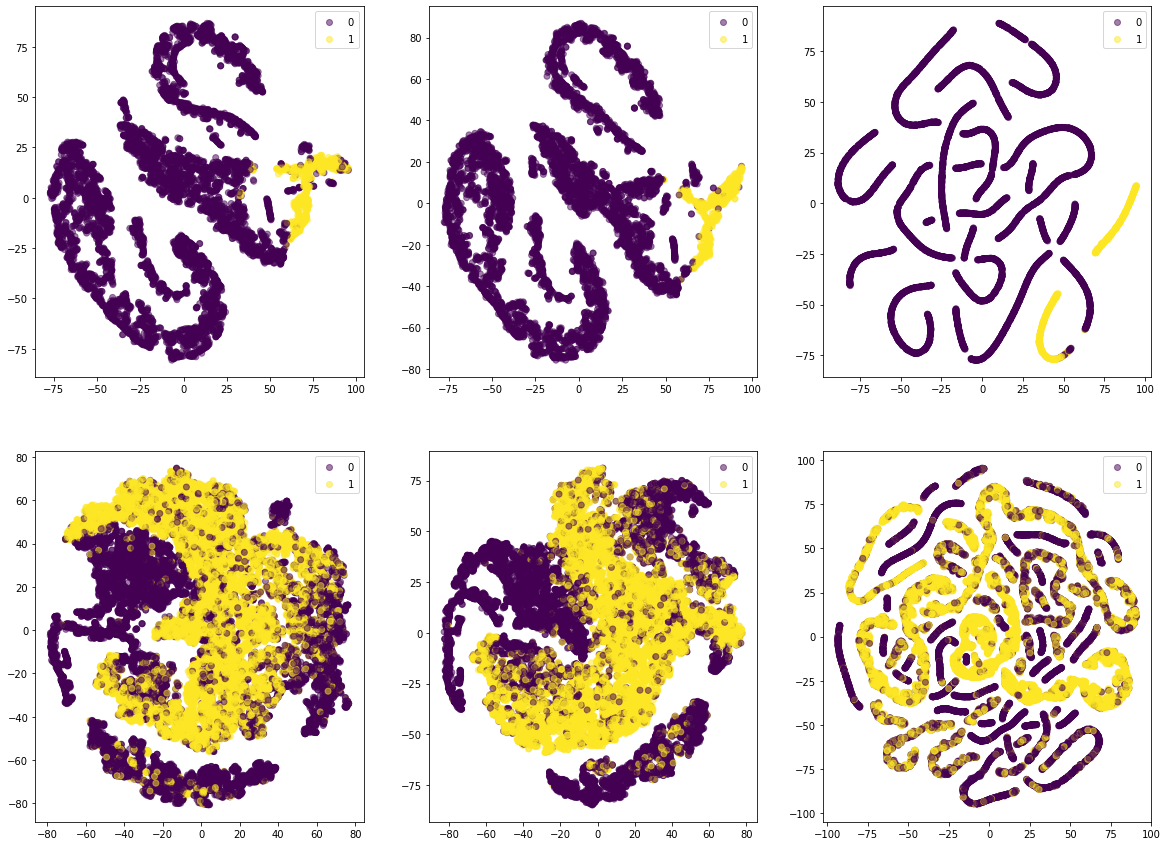

In [47]:
N_CURVES = 25000

fig, axs = plt.subplots(2, 3, figsize=(20,15))
intermediate_tsne_data, intermediate_tsne_data_test = get_tsne(intermediates, data_test= intermediates_test, n_curves = N_CURVES)
plot_representations(intermediate_tsne_data, labels, axs[0, 0],  n_curves = N_CURVES)
plot_representations(intermediate_tsne_data_test, labels_test, axs[1, 0], n_curves = N_CURVES)

intermediate2_tsne_data, intermediate2_tsne_data_test = get_tsne(intermediates2, data_test=intermediates2_test, n_curves = N_CURVES)
plot_representations(intermediate2_tsne_data, labels, axs[0, 1], n_curves = N_CURVES)
plot_representations(intermediate2_tsne_data_test, labels_test, axs[1, 1], n_curves = N_CURVES)

output_tsne_data, output2_tsne_data_test = get_tsne(outputs, data_test=outputs_test, n_curves = N_CURVES)
plot_representations(output_tsne_data, labels, axs[0, 2], n_curves = N_CURVES)
plot_representations(output2_tsne_data_test, labels_test, axs[1, 2], n_curves = N_CURVES)

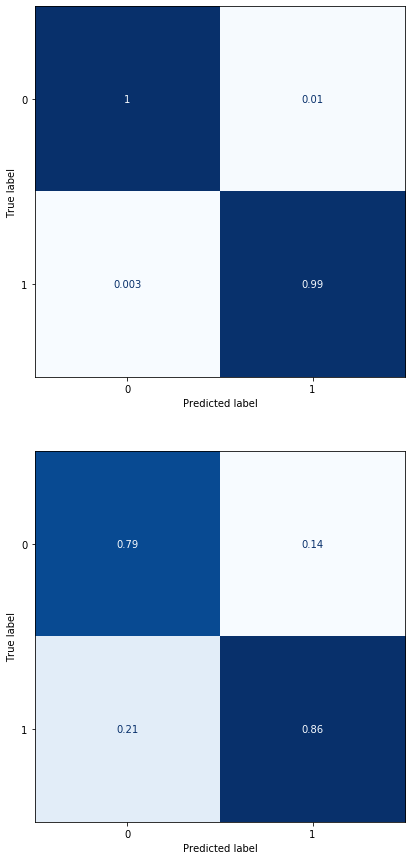

In [48]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,15))
curves, labels, probs_train = get_predictions(net, train_loader_pred, device)
#pred_labels = torch.argmax(probs_train, 1)
pred_labels = probs_train.argmax(1, keepdim = True)

plot_confusion_matrix(np.round(labels), pred_labels, ax1)
curves, labels, probs_test = get_predictions(net, test_loader_pred, device)
pred_labels = probs_test.argmax(1, keepdim = True)

#pred_labels = torch.argmax(probs_test, 1)
plot_confusion_matrix(np.round(labels), pred_labels, ax2)

In [49]:
print(len(train_tensor))
print(len(train_tensor_pred))

7025
7806


In [50]:
curves, labels, probs_train_sample = get_predictions(net, train_loader, device)

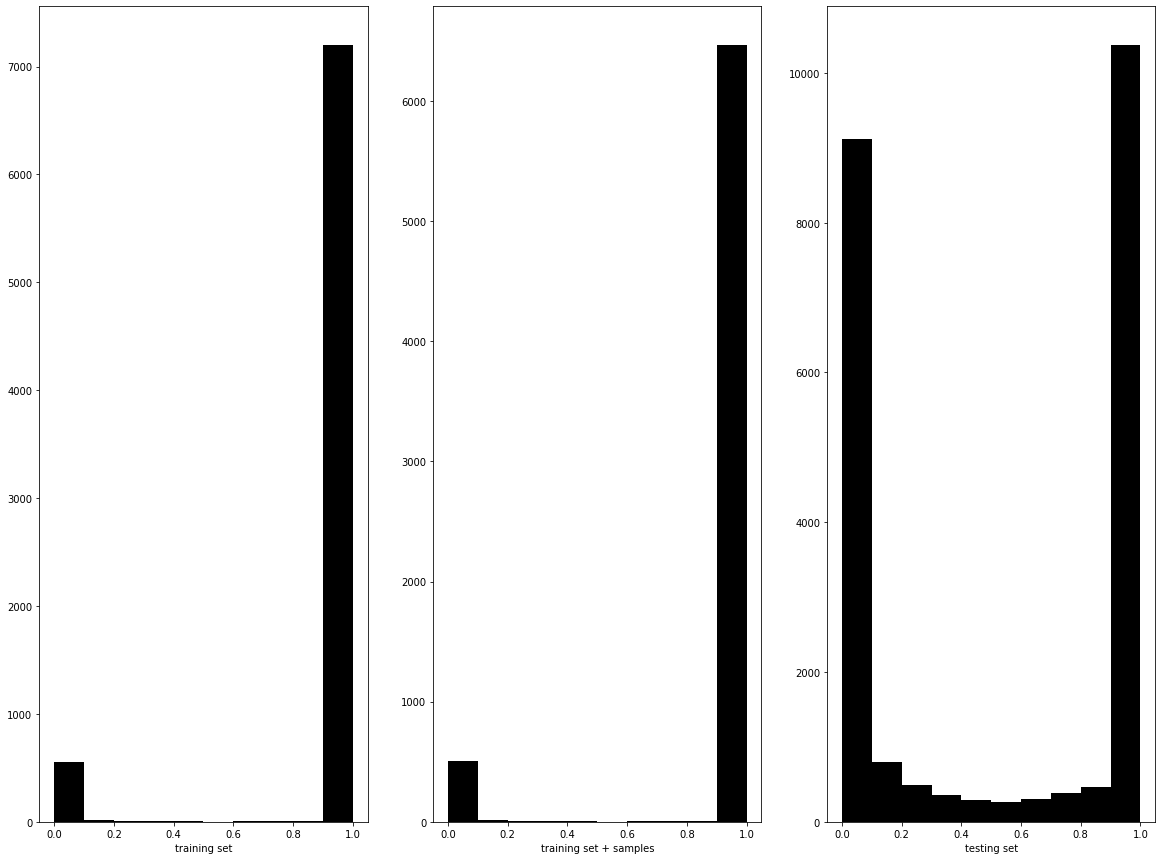

In [51]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,15))
ax1.hist(probs_train[:,0], color='black')
ax1.set_xlabel('training set')
ax2.hist(probs_train_sample[:,0], color='black')
ax2.set_xlabel('training set + samples')
ax3.hist(probs_test[:,0], color='black')
ax3.set_xlabel('testing set')
plt.show()

In [52]:
np.round(softmax(outputs))

tensor([[nan, 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [1., 0.],
        [nan, 0.]])

RuntimeError: shape '[5, 10]' is invalid for input of size 100

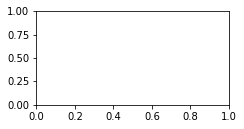

In [53]:
N_WEIGHTS = 25
weights = net.fc2.weight.data
plot_weights(weights, N_WEIGHTS)

In [ ]:
weights1 = net.fc1.weight.data
w1 = weights1.cpu().numpy().reshape(-1,1)
weights2 = net.fc2.weight.data
w2 = weights2.cpu().numpy().reshape(-1,1)
weights3 = net.fc3.weight.data
w3 = weights3.cpu().numpy().reshape(-1,1)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,15))

ax1.hist(w1, color='black')
ax1.set_xlabel('Layer 1')
ax2.hist(w2, color='black')
ax2.set_xlabel('Layer 2')
ax3.hist(w3, color='black')
ax3.set_xlabel('Layer 3')
plt.show()